In [1]:
# 🔹 2. Importar bibliotecas necessárias
from openai import OpenAI
import os
import pandas as pd
from dotenv import load_dotenv

load_dotenv()
# 🔹 3. Configurar a chave de API
# Defina sua chave de API como variável de ambiente ou diretamente aqui (não recomendado em notebooks públicos)
# os.environ["OPENAI_API_KEY"] = "sk-xxxx"
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

In [2]:
# 🔹 4. Função para enviar prompt e capturar logprobs
def ask_gpt_with_logprobs(prompt: str, model: str = "gpt-4o-mini", top_logprobs: int = 5):
    """
    Envia um prompt ao modelo GPT e retorna:
      - resposta gerada
      - DataFrame com tokens e logprobs
    """
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        logprobs=True,
        top_p=0.9,
        top_logprobs=top_logprobs,
        max_tokens=10
    )

    # Extrair texto principal
    message = response.choices[0].message.content

    # Acessar tokens com logprobs
    token_data = response.choices[0].logprobs.content  # lista de ChatCompletionTokenLogprob

    # Extrair informações relevantes
    tokens, logprobs, top_alternatives = [], [], []
    for t in token_data:
        tokens.append(t.token)
        logprobs.append(t.logprob)
        # Salva as top alternativas para análise posterior
        alt = [(alt.token, alt.logprob) for alt in t.top_logprobs]
        top_alternatives.append(alt)

    # Criar tabela
    df = pd.DataFrame({
        "Token": tokens,
        "LogProb": logprobs,
        "Top Alternatives": top_alternatives
    })

    return message, df


In [7]:
# 🔹 5. Teste da função
prompt = "Complete a frase: O rato roeu a roupa do rei de ."
# prompt = "Complete a frase: Deus ajuda quem "
resposta, tabela_logprobs = ask_gpt_with_logprobs(prompt)


# 🔹 6. Exibir resultados
print("🧠 Resposta do GPT:\n", resposta)
print("\n📊 Tokens e LogProbs:\n")
display(tabela_logprobs)

🧠 Resposta do GPT:
 O rato roeu a roupa do rei de Roma

📊 Tokens e LogProbs:



,Token,LogProb,Top Alternatives
0,O,-4.293273e-03,"[(O, -0.004293272737413645), (""O, -6.004293441..."
1,rato,-3.128163e-07,"[( rato, -3.128163257315464e-07), ( rat, -15.8..."
2,ro,0.000000e+00,"[( ro, 0.0), (-ro, -17.875), (ro, -18.5), ( r,..."
3,eu,-3.128163e-07,"[(eu, -3.128163257315464e-07), (Eu, -15.375), ..."
4,a,0.000000e+00,"[( a, 0.0), ( A, -18.875), ( à, -20.125), ( а,..."
5,roupa,-1.449805e-05,"[( roupa, -1.4498052223643754e-05), ( ropa, -1..."
6,do,0.000000e+00,"[( do, 0.0), ( da, -19.125), (do, -20.25), ( d..."
7,rei,-5.133198e-05,"[( rei, -5.133198283147067e-05), ( Rei, -10.00..."
8,de,-2.985774e-02,"[( de, -0.029857739806175232), ( da, -3.529857..."
9,Roma,-4.143576e-03,"[( Roma, -0.0041435761377215385), ( França, -5..."


In [4]:
!pip install matplotlib

In [8]:
# 🔹 7. Visualizar probabilidades alternativas de tokens
import math
import matplotlib.pyplot as plt

def plot_token_alternatives(df, token_index=0):
    """
    Mostra um gráfico de barras com as top alternativas de token e suas probabilidades reais (exp(logprob)).
    """
    if token_index >= len(df):
        print("Índice fora do intervalo. Escolha entre 0 e", len(df)-1)
        return
    
    token_info = df.iloc[token_index]
    alternatives = token_info["Top Alternatives"]
    
    tokens = [t[0] for t in alternatives]
    probs = [math.exp(t[1]) for t in alternatives]  # converte logprobs para probabilidade real
    probs = [p / sum(probs) for p in probs]  # normaliza para somar 1

    plt.figure(figsize=(8, 4))
    plt.bar(tokens, probs)
    plt.title(f"Distribuição de Probabilidades - Token {token_index}: '{token_info['Token']}'")
    plt.ylabel("Probabilidade normalizada")
    plt.xlabel("Alternativas de tokens")
    plt.show()



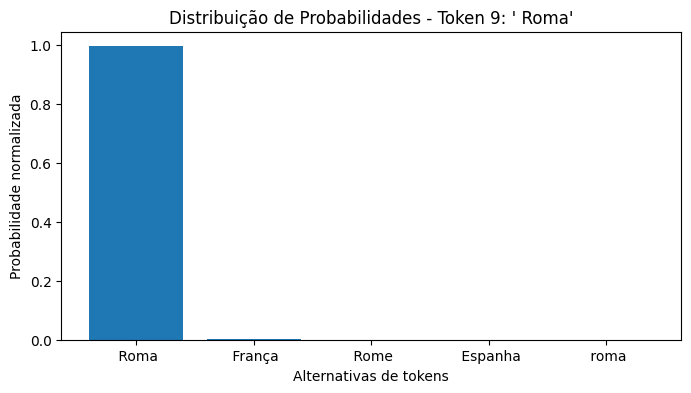

In [10]:
# Exemplo: exibir o gráfico das alternativas do 5º token
plot_token_alternatives(tabela_logprobs, token_index=9)